In [1]:
from PIL import Image
import numpy as np

In [2]:
grey_image = Image.open('data/CFA.bmp')

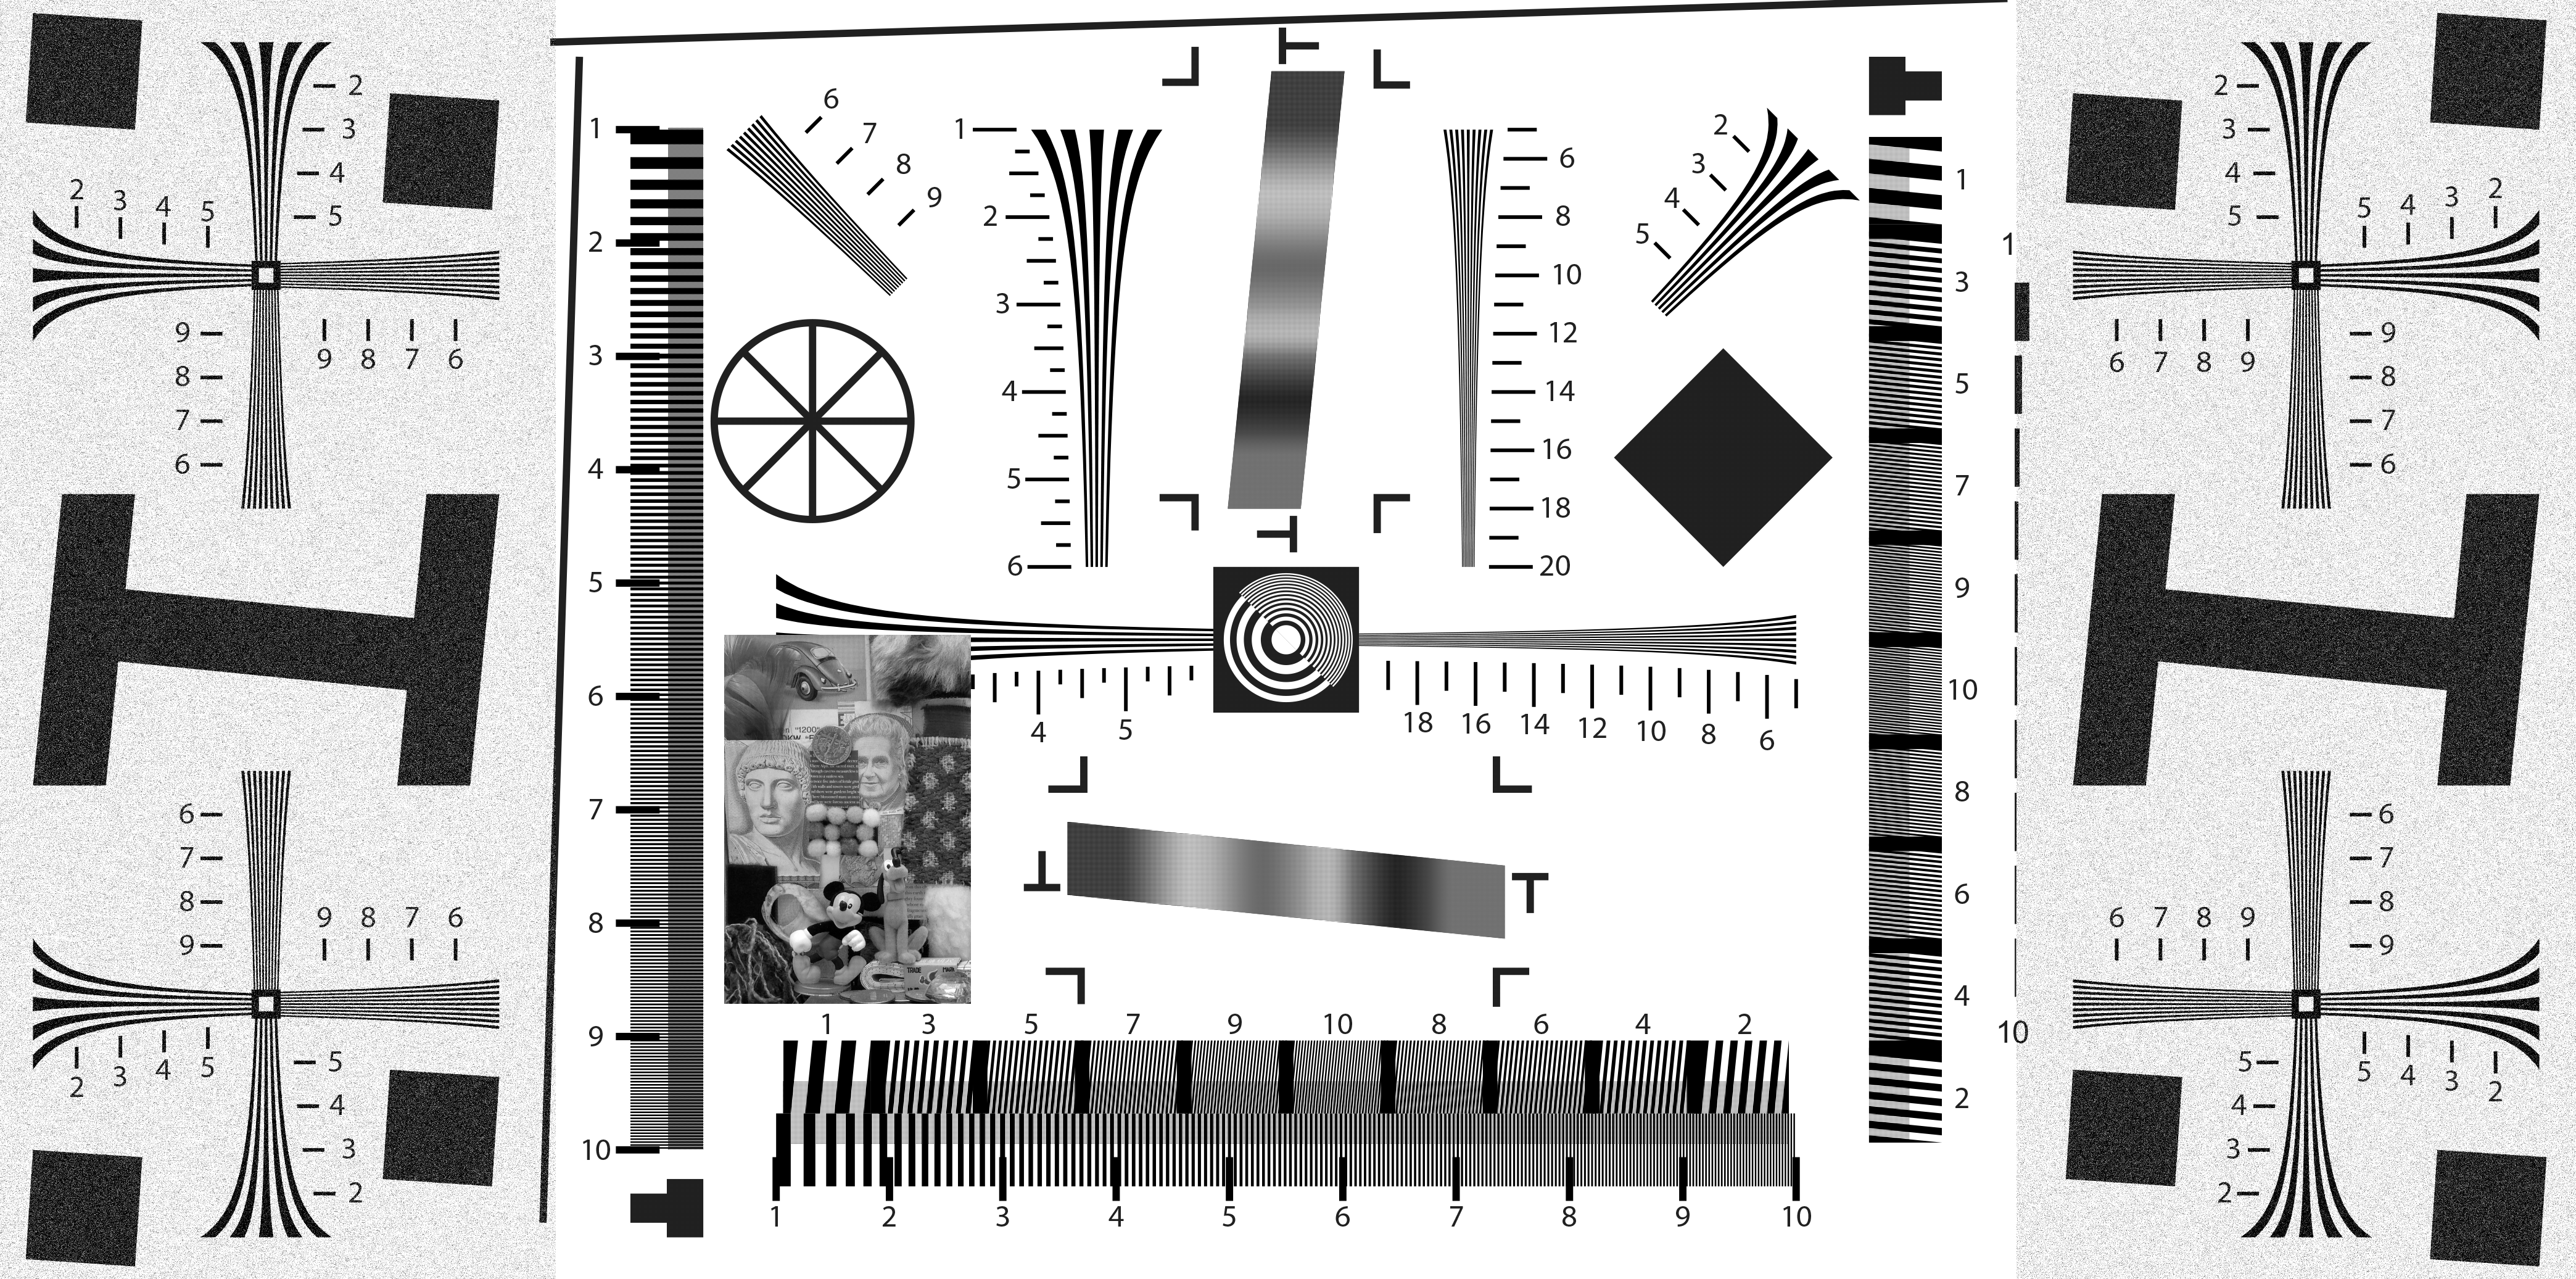

In [3]:
grey_image

In [4]:
grey_image_arr = np.array(grey_image)

In [22]:
grey_image_arr

array([[  0,   0,   0, ...,  17,  49,   0],
       [ 91,  47,   0, ...,  10,   0,  41],
       [106,   0,  56, ...,  11,  31,   0],
       ...,
       [  0,   0,   5, ...,   0,   0,   0],
       [  0,   0,  89, ...,   0,  81,  12],
       [  0,  52,  45, ...,   0,   0,   0]], dtype=uint8)

In [15]:
image = Image.open('data/RGB_CFA.bmp')

In [16]:
image_arr = np.array(image)

In [58]:
((image_arr == 0).sum(axis=-1) == 3).sum()

822594

In [24]:
grey_image_arr.shape

(2073, 4176)

In [62]:
window_size = 5
window_half = window_size // 2

In [63]:
height_start = window_size // 2
height_end = image_arr.shape[0] - window_size // 2

width_start = window_size // 2
width_end = image_arr.shape[1] - window_size // 2

In [64]:
red = 0
green = 1
blue = 2

In [144]:
def calc_cardinal_grads(g1, b1, g2, b2, g3,
                        r1, g4, r2, g5, r3,
                        g6, b3, g7, b4, g8,
                        r4, g9, r5, g10, r6,
                        g11, b5, g12, b6, g13):

    gradN = abs(r2 - r5) + abs(g2 - g7) + abs(g4 - g9)/2 +  \
            abs(g5 - g10)/2 + abs(b1-b3)/2 + abs(b2-b4)/2

    gradE = abs(b4 - b3) + abs(g8 - g7) + abs(g5 - g4)/2 +  \
            abs(g10 - g9)/2 + abs(r3-r2)/2 + abs(r6-r5)/2

    gradS = abs(r5 - r2) + abs(g12 - g7) + abs(g9 - g4)/2 + \
            abs(g10 - g5)/2 + abs(b5-b3)/2 + abs(b6-b4)/2

    gradW = abs(b3 - b4) + abs(g6 - g7) + abs(g4 - g5)/2 +  \
            abs(g9 - g10)/2 + abs(r1-r2)/2 + abs(r4-r5)/2

    return gradN, gradE, gradS, gradW

def calc_ordinal_grads(g1, b1, g2, b2, g3,
                       r1, g4, r2, g5, r3,
                       g6, b3, g7, b4, g8,
                       r4, g9, r5, g10, r6,
                       g11, b5, g12, b6, g13, color):

    if color == green:
        gradNE = abs(g5 - g9) + abs(g3 - g7) + abs(b2 - b3) + abs(r3 - r5)

        gradSE = abs(g10 - g4) + abs(g13 - g7) + abs(b6 - b3) + abs(r6 - r2)

        gradNW = abs(g4 - g10) + abs(g1 - g7) + abs(b1 - b4) + abs(r1 - r5)

        gradSW = abs(g9 - g5) + abs(g11 - g7) + abs(b5 - b4) + abs(r4 - r2)
    else:
        gradNE = abs(g5 - g9) + abs(g3 - g7) + (abs(r2 - b3) + abs(b4 - r5) + abs(b2 - r2) + abs(r3 - b4))/2

        gradSE = abs(g10 - g4) + abs(g13 - g7) + (abs(r5 - b3) + abs(b6 - r5) + abs(r6 - b4) + abs(r2 - b4))/2

        gradNW = abs(g4 - g10) + abs(g1 - g7) + (abs(r1 - b3) + abs(b3 - r5) + abs(b1 - r2) + abs(r2 - b4))/2

        gradSW = abs(g9 - g5) + abs(g11 - g7) + (abs(r4 - b3) + abs(b3 - r2) + abs(b5 - r5) + abs(r5 - b4))/2

    return gradNE, gradSE, gradNW, gradSW

def mean_colors_green(g1, b1, g2, b2, g3,
                      r1, g4, r2, g5, r3,
                      g6, b3, g7, b4, g8,
                      r4, g9, r5, g10, r6,
                      g11, b5, g12, b6, g13):

     return   {'N' : {'R': r2,              'G' : (g2 + g7)/2,  'B': (b1+b2+b3+b4)/4},
               'E' : {'R': (r2+r3+r5+r6)/4, 'G' : (g7 + g8)/2,  'B': b4},
               'S' : {'R': r5,              'G' : (g7 + g12)/2, 'B': (b3+b4+b5+b6)/4},
               'W' : {'R': (r1+r2+r4+r5)/4, 'G' : (g6 + g7)/2,  'B': b3},
               'NE' : {'R': (r2+r3)/2,      'G' : g5,           'B': (b2+b4)/2},
               'SE' : {'R': (r5+r6)/2,      'G' : g10,          'B': (b4+b6)/2},
               'NW' : {'R': (r1+r2)/2,      'G' : g4,           'B': (b1+b3)/2},
               'SW' : {'R': (r4+r5)/2,      'G' : g9,           'B': (b3+b5)/2} }

def mean_colors_redblue(g1, b1, g2, b2, g3,
                        r1, g4, r2, g5, r3,
                        g6, b3, g7, b4, g8,
                        r4, g9, r5, g10, r6,
                        g11, b5, g12, b6, g13):

     return   {'N' : {'R':  (g2+g7)/2,   'G' : r2,                  'B': (g4+g5)/2},
               'E' : {'R':  (g7+g8)/2,   'G' : b4,                  'B': (g5+g10)/2},
               'S' : {'R':  (g7+g12)/2,  'G' : r5,                  'B': (g9+g10)/2},
               'W' : {'R':  (g7+g6)/2,   'G' : b3,                  'B': (g4+g9)/2},
               'NE' : {'R': (g7+g3)/2,   'G' : (r2+b2+r3+b4)/4,     'B': g5 },
               'SE' : {'R': (g7+g13)/2,  'G' : (b4+b6+r5+r6)/4,     'B': g10 },
               'NW' : {'R': (g7+g1)/2,   'G' : (r1+b1+r2+b3)/4,     'B': g4 },
               'SW' : {'R': (g7+g11)/2,  'G' : (b3+b5+r4+r5)/4,     'B': g9 } }

In [266]:
def calc_grads(image, h, w):
    color = get_color(h , w)
    color_up = get_color(h + 1 , w)

    window = 255 - np.array(image[h - window_half : h + window_half + 1,
                                  w - window_half : w + window_half + 1]).flatten()

    window = window.tolist()

    g1, b1, g2, b2, g3,   \
    r1, g4, r2, g5, r3,   \
    g6, b3, g7, b4, g8,   \
    r4, g9, r5, g10, r6,  \
    g11, b5, g12, b6, g13 = window

    gradN, gradE, gradS, gradW = calc_cardinal_grads(*window)

    gradNE, gradSE, gradNW, gradSW = calc_ordinal_grads(*window, color)

    directions_grads = [gradN, gradE, gradS, gradW, gradNE, gradSE, gradNW, gradSW]
    directions_names = ['N', 'E', 'S', 'W', 'NE', 'SE', 'NW', 'SW']

    min_grad = min(directions_grads)
    max_grad = max(directions_grads)

    T = 1.5 * min_grad + 0.5 * (max_grad + min_grad)

    mean_colors = mean_colors_green(*window) if color == green else mean_colors_redblue(*window)

    accepted_directions = [directions_names[i] for i in range(len(directions_grads)) if directions_grads[i] <= T]

    if not accepted_directions:
        return image[h, w, :], 0

    red_sum = green_sum = blue_sum = 0

    for direct in accepted_directions:
        green_sum += mean_colors[direct]['G']
        if color_up == red:
            red_sum += mean_colors[direct]['R']
            blue_sum += mean_colors[direct]['B']
        else:
            red_sum += mean_colors[direct]['B']
            blue_sum += mean_colors[direct]['R']

    cur_sum = (red_sum, green_sum, blue_sum)[color]

    cur_red   = g7 + (red_sum   - cur_sum) / len(accepted_directions)
    cur_green = g7 + (green_sum - cur_sum) / len(accepted_directions)
    cur_blue  = g7 + (blue_sum  - cur_sum) / len(accepted_directions)

    return np.array([cur_red, cur_green, cur_blue]), len(accepted_directions)

In [275]:
a = np.array([1, 2, 3])

In [276]:
a[:] = 1

In [277]:
a

array([1, 1, 1])

In [200]:
def get_color(h, w):
    return w % 2 + h % 2

In [199]:
np.argmax([0,0,0])

0

In [112]:
from tqdm.notebook import tqdm

In [281]:
demosaiced_image = np.zeros(image_arr.shape)
directs_num = []

for h in tqdm(range(height_start, height_end)):
    for w in range(width_start, width_end):
        demosaiced_image[h, w, :], directions_num = calc_grads(cfa_image_arr, h, w)
        directs_num.append(directions_num)

  0%|          | 0/2069 [00:00<?, ?it/s]

In [291]:
demosaiced_image[demosaiced_image > 255] = 255
demosaiced_image[demosaiced_image < 0] = 0

In [300]:
"{:.3f}".format(2.1234567)

'2.123'

In [191]:
directs_num[int(4076 * 2.5)]

0

In [194]:
demosaiced_image[2, 4076 // 2, :]

array([255.,   0.,   0.])

In [102]:
a, b, c, d = np.array([[1, 2], [3, 4]]).flatten().tolist()

In [293]:
new_image = Image.fromarray(demosaiced_image.astype(np.uint8))

In [308]:
colors_set_processed = set()
colors_set_original = set()

for h in range(demosaiced_image.shape[0]):
    for w in range(demosaiced_image.shape[1]):
        colors_set_processed.add(tuple(demosaiced_image[h][w].astype(np.uint8)))
        colors_set_original.add(tuple(original_arr[h][w]))

In [309]:
len(colors_set_original)

525915

In [310]:
len(colors_set_processed)

1051622

In [294]:
new_image.save('processed.png')

In [269]:
new_image.show()

In [254]:
image_arr[0][0]

array([255,   0,   0], dtype=uint8)

In [119]:
processed = Image.fromarray(demosaiced_image)

TypeError: Cannot handle this data type: (1, 1, 3), <f8

In [218]:
def get_psnr(original, processed):
    MSE = 0
    for h in range (original.shape[0]):
        for w in range(original.shape[1]):
            r1, g1, b1 = original[h, w, :].tolist()
            r2, g2, b2 = processed[h, w, :].tolist()
            MSE += (0.299*(r2 - r1) + 0.587*(g2 - g1) + 0.114*(b2 - b1))**2

    MSE /= (original.shape[0] * original.shape[1])

    PSNR = 10 * np.log10(255**2 / MSE)

    return PSNR

In [282]:
original_arr = np.array(Image.open('data/Original.bmp'))

In [292]:
get_psnr(original_arr.astype(np.uint8), demosaiced_image.astype(np.uint8))

21.767111241906683

In [127]:
Image.fromarray(demosaiced_image)

TypeError: Cannot handle this data type: (1, 1, 3), <f8

In [258]:
def get_bayer_rgb(cfa_image):
    cfa_rgb = np.zeros((cfa_image.shape[0], cfa_image.shape[1], 3))
    for h in range(cfa_image.shape[0]):
        for w in range(cfa_image.shape[1]):
            cfa_rgb[h, w, get_color(h, w)] = 255 - cfa_image[h][w]

    return cfa_rgb

In [279]:
cfa_image = Image.open('data/CFA.bmp')

In [257]:
cfa_image_arr

array([[  0,   0,   0, ...,  17,  49,   0],
       [ 91,  47,   0, ...,  10,   0,  41],
       [106,   0,  56, ...,  11,  31,   0],
       ...,
       [  0,   0,   5, ...,   0,   0,   0],
       [  0,   0,  89, ...,   0,  81,  12],
       [  0,  52,  45, ...,   0,   0,   0]], dtype=uint8)

In [256]:
image_arr.max(axis=-1)

array([[255, 255, 255, ..., 238, 206, 255],
       [164, 208, 255, ..., 245, 255, 214],
       [149, 255, 199, ..., 244, 224, 255],
       ...,
       [255, 255, 250, ..., 255, 255, 255],
       [255, 255, 166, ..., 255, 174, 243],
       [255, 203, 210, ..., 255, 255, 255]], dtype=uint8)

In [239]:
cfa_image.show()

In [280]:
cfa_image_arr = np.array(cfa_image)

In [249]:
cfa_image_arr.

(2073, 4176)

In [259]:
rgb_bayer = get_bayer_rgb(cfa_image_arr)

In [260]:
rgb_bayer_image = Image.fromarray(rgb_bayer.astype(np.uint8))

In [261]:
rgb_bayer_image.show()